In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\juand\.cache\kagglehub\datasets\abdallahalidev\plantvillage-dataset\versions\3


# Imports y ruta

In [55]:

# Imports necesarios para procesamiento de imágenes
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

## Verificación de Dimensiones de Imágenes

Esta función verifica si todas las imágenes en un directorio tienen las mismas dimensiones. Es útil para asegurar la consistencia del dataset antes de entrenar modelos de machine learning, especialmente cuando se requiere que todas las imágenes tengan el mismo tamaño (como 256x256 píxeles).


In [ ]:
def verificar_dimensiones_imagenes(directorio, dimensiones_esperadas=(256, 256)):
    """
    Verifica si todas las imágenes en un directorio tienen las mismas dimensiones.
    
    Args:
        directorio (str): Ruta al directorio que contiene las imágenes
        dimensiones_esperadas (tuple): Dimensiones esperadas (ancho, alto). Default: (256, 256)
    
    Returns:
        dict: Diccionario con información sobre la verificación
    """
    import os
    from PIL import Image
    
    # Obtener lista de archivos de imagen
    extensiones_validas = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.JPG', '.JPEG', '.PNG')
    archivos_imagen = [f for f in os.listdir(directorio) if f.endswith(extensiones_validas)]
    
    if not archivos_imagen:
        return {"error": "No se encontraron archivos de imagen en el directorio"}
    
    # Verificar cada imagen
    dimensiones_encontradas = set()
    imagenes_problematicas = []
    total_imagenes = len(archivos_imagen)
    
    for archivo in archivos_imagen:
        try:
            ruta_completa = os.path.join(directorio, archivo)
            with Image.open(ruta_completa) as img:
                dimensiones = img.size  # (ancho, alto)
                dimensiones_encontradas.add(dimensiones)
                
                if dimensiones != dimensiones_esperadas:
                    imagenes_problematicas.append({
                        'archivo': archivo,
                        'dimensiones': dimensiones,
                        'esperadas': dimensiones_esperadas
                    })
        except Exception as e:
            imagenes_problematicas.append({
                'archivo': archivo,
                'error': str(e)
            })
    
    # Resultados
    todas_iguales = len(dimensiones_encontradas) == 1
    dimensiones_correctas = todas_iguales and list(dimensiones_encontradas)[0] == dimensiones_esperadas
    
    return {
        'total_imagenes': total_imagenes,
        'dimensiones_esperadas': dimensiones_esperadas,
        'dimensiones_encontradas': list(dimensiones_encontradas),
        'todas_iguales': todas_iguales,
        'dimensiones_correctas': dimensiones_correctas,
        'imagenes_problematicas': imagenes_problematicas,
        'porcentaje_correcto': ((total_imagenes - len(imagenes_problematicas)) / total_imagenes) * 100
    }

# Ejemplo de uso
resultado = verificar_dimensiones_imagenes("plantvillage dataset/color/Potato___Early_blight")
print(f"Total de imágenes: {resultado['total_imagenes']}")
print(f"Dimensiones encontradas: {resultado['dimensiones_encontradas']}")
print(f"Todas tienen las mismas dimensiones: {resultado['todas_iguales']}")
print(f"Dimensiones correctas (256x256): {resultado['dimensiones_correctas']}")
print(f"Porcentaje correcto: {resultado['porcentaje_correcto']:.1f}%")

if resultado['imagenes_problematicas']:
    print(f"\nImágenes problemáticas: {len(resultado['imagenes_problematicas'])}")
    for img in resultado['imagenes_problematicas'][:5]:  # Mostrar solo las primeras 5
        print(f"  - {img['archivo']}: {img.get('dimensiones', 'Error al cargar')}")


Total de imágenes: 1000
Dimensiones encontradas: [(256, 256)]
Todas tienen las mismas dimensiones: True
Dimensiones correctas (256x256): True
Porcentaje correcto: 100.0%


## Estructura de una Imagen Digital

### Dimensiones de una Imagen (256, 256, 3)

Una imagen digital se representa como un **tensor de 3 dimensiones**:

1. **Primera dimensión (256)**: **Filas** - Altura de la imagen en píxeles
2. **Segunda dimensión (256)**: **Columnas** - Ancho de la imagen en píxeles  
3. **Tercera dimensión (3)**: **Canales de color** - RGB (Red, Green, Blue)

### ¿Qué es un canal de color?

Cada píxel de una imagen a color se compone de **3 valores**:
- **Canal Rojo (R)**: Intensidad del rojo (0-255)
- **Canal Verde (G)**: Intensidad del verde (0-255)
- **Canal Azul (B)**: Intensidad del azul (0-255)

### Estructura de la Matriz

```
Imagen[256, 256, 3] = [
  [píxel(0,0) = [R, G, B], píxel(0,1) = [R, G, B], ..., píxel(0,255) = [R, G, B]],
  [píxel(1,0) = [R, G, B], píxel(1,1) = [R, G, B], ..., píxel(1,255) = [R, G, B]],
  ...
  [píxel(255,0) = [R, G, B], píxel(255,1) = [R, G, B], ..., píxel(255,255) = [R, G, B]]
]
```

### Ejemplo Práctico

Si tienes un píxel en la posición (100, 150):
- `imagen[100, 150, 0]` = Valor del canal Rojo
- `imagen[100, 150, 1]` = Valor del canal Verde  
- `imagen[100, 150, 2]` = Valor del canal Azul
- `imagen[100, 150, :]` = [R, G, B] completo del píxel


## Dataset estilo MNIST para papas (Early_blight, Late_blight, healthy)
Cargamos imágenes desde `plantvillage dataset/color` y construimos `(x_train, y_train), (x_test, y_test)` con `shape` similar a MNIST.


In [ ]:

# Directorio raíz y clases de interés
root_dir = "plantvillage dataset/segmented"
class_names = [
    "Potato___Early_blight",
    "Potato___Late_blight",
    "Potato___healthy",
]

img_size = (256, 256)
color_mode = "rgb"  # 3 canales
val_split = 0.2
seed = 42

# Cargar datasets como tf.data.Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    root_dir,
    labels="inferred",
    label_mode="int",
    class_names=class_names,   # limita a las clases de papa
    image_size=img_size,
    color_mode=color_mode,
    validation_split=val_split,
    subset="training",
    seed=seed,
    shuffle=True,
    batch_size=32,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    root_dir,
    labels="inferred",
    label_mode="int",
    class_names=class_names,
    image_size=img_size,
    color_mode=color_mode,
    validation_split=val_split,
    subset="validation",
    seed=seed,
    shuffle=False,
    batch_size=32,
)

# Normalizar 0-1 y cachear para velocidad
rescale = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (rescale(x), y)).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(lambda x, y: (rescale(x), y)).cache().prefetch(tf.data.AUTOTUNE)

# Utilidad: convertir tf.data -> numpy (concatenando batches)
def dataset_to_numpy(ds):
    xs = []
    ys = []
    for xb, yb in ds:
        xs.append(xb.numpy())
        ys.append(yb.numpy())
    x = np.concatenate(xs, axis=0)
    y = np.concatenate(ys, axis=0)
    return x, y

x_train, y_train = dataset_to_numpy(train_ds)
x_test, y_test = dataset_to_numpy(test_ds)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print("Clases:", class_names)


Found 2152 files belonging to 3 classes.


Using 1722 files for training.
Found 2152 files belonging to 3 classes.
Using 430 files for validation.
(1722, 256, 256, 3) (1722,) (430, 256, 256, 3) (430,)
Clases: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [ ]:
#@title **code** To normalize and prepare data
x_train = x_train.reshape([-1, 256, 256, 3]) #para pasar un grupo de imagenes "batch"
x_test = x_test.reshape([-1, 256, 256, 3]) #"-1 es un batch variable 

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0])
print('Number of images in x_test', x_test.shape[0])

x_train shape: (1722, 256, 256, 3)
Number of images in x_train 1722
Number of images in x_test 430


In [ ]:

model = tf.keras.Sequential([
    tf.keras.layers.Flatten( input_shape=[256, 256, 3]),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(3, activation=tf.nn.softmax)
])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 196608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │    50,331,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │        65,792 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,463,488 (192.50 MB)

 Trainable params: 50,463,488 (192.50 MB)

 Non-trainable params: 0 (0.00 B)

In [80]:
import tensorflow as tf
import numpy as np

num_classes = 3
target_size = (128, 128)  # bajar resolución para hacer viable el MLP

# 1) Preprocesar: redimensionar, normalizar y aplanar
def prep_xy(x, y):
    x = tf.image.resize(x, target_size)           # (H,W,3)
    x = tf.cast(x, tf.float32)
    if tf.reduce_max(x) > 1.0:
        x = x / 255.0
    x = tf.reshape(x, (-1,))                      # flatten
    return x, y

bs = 64
train_ds_pp = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(prep_xy, num_parallel_calls=tf.data.AUTOTUNE).shuffle(8192).batch(bs).cache().prefetch(tf.data.AUTOTUNE)
val_ds_pp   = tf.data.Dataset.from_tensor_slices((x_test,  y_test)).map(prep_xy, num_parallel_calls=tf.data.AUTOTUNE).batch(bs).cache().prefetch(tf.data.AUTOTUNE)

# 2) Modelo MLP con regularización
reg = tf.keras.regularizers.l2(1e-4)
inputs = tf.keras.Input(shape=(target_size[0]*target_size[1]*3,))
x = tf.keras.layers.BatchNormalization()(inputs)
x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer=reg)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=reg)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=reg)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

# 3) Optimizador + callbacks
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
]


# 4) (Opcional) ponderar clases si hay desbalance
unique, counts = np.unique(y_train, return_counts=True)
class_weights = {int(c): float(np.sum(counts)/cnt) for c, cnt in zip(unique, counts)}

history = model.fit(
    train_ds_pp,
    validation_data=val_ds_pp,
    epochs=20,
    callbacks=callbacks,
    class_weight=class_weights,  # quita este argumento si no quieres ponderación
    verbose=1,
)

Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 458ms/step - accuracy: 0.6527 - loss: 2.9976 - val_accuracy: 0.0000e+00 - val_loss: 1.9971 - learning_rate: 0.0010
Epoch 2/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 458ms/step - accuracy: 0.7747 - loss: 1.9420 - val_accuracy: 0.0000e+00 - val_loss: 2.2144 - learning_rate: 0.0010
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 458ms/step - accuracy: 0.8258 - loss: 1.6870 - val_accuracy: 0.0000e+00 - val_loss: 2.7573 - learning_rate: 0.0010
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.8515 - loss: 1.5046
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 460ms/step - accuracy: 0.8630 - loss: 1.4370 - val_accuracy: 0.0000e+00 - val_loss: 3.3813 - learning_rate: 0.0010
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 458ms/step - accuracy: 0.8978 - loss: 1.2107 - val_accuracy: 0.0000e+00 - val_loss: 3.0583 - learning_rate: 5.0000e-04
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 444ms/step - accur

KeyboardInterrupt: 

In [77]:
# Usa el MISMO preprocesamiento que en entrenamiento
import tensorflow as tf
import numpy as np

target_size = (128, 128)

def prep_xy(x, y):
    x = tf.image.resize(x, target_size)
    x = tf.cast(x, tf.float32)
    if tf.reduce_max(x) > 1.0:
        x = x / 255.0
    x = tf.reshape(x, (-1,))
    return x, tf.cast(y, tf.int32)

bs = 64
val_ds_pp_eval = tf.data.Dataset.from_tensor_slices((x_test, y_test)) \
    .map(prep_xy, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(bs) \
    .prefetch(tf.data.AUTOTUNE)

test_loss, test_acc = model.evaluate(val_ds_pp_eval, verbose=1)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.4721 - loss: 1.5307
Test loss: 1.5307209491729736
Test accuracy: 0.47209301590919495


In [ ]:
# ======================= IMPORTS =======================
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# =================== CONFIGURACIÓN =====================
root_dir = "plantvillage dataset/color"
# Orden de clases FIJO (debe usarse igual en entrenamiento e inferencia)
class_names_used = [
    "Potato___Early_blight",
    "Potato___Late_blight",
    "Potato___healthy",
]

img_size_raw = (256, 256)   # tamaño de carga desde disco
target_size = (128, 128)    # tamaño para el MLP (reduce parámetros)
val_split = 0.2
seed = 42
batch = 32
num_classes = len(class_names_used)

# ================== DATASET (RAW, CON ETIQUETAS) ==================
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    root_dir,
    labels="inferred",
    label_mode="int",
    class_names=class_names_used,
    image_size=img_size_raw,
    color_mode="rgb",
    validation_split=val_split,
    subset="training",
    seed=seed,
    shuffle=True,
    batch_size=batch,
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    root_dir,
    labels="inferred",
    label_mode="int",
    class_names=class_names_used,
    image_size=img_size_raw,
    color_mode="rgb",
    validation_split=val_split,
    subset="validation",
    seed=seed,
    shuffle=False,
    batch_size=batch,
)

print("Orden de clases (fijo):", class_names_used)

# ========== PREPROCESAMIENTO PARA ENTRENAR EL MLP (MAP) ===========
# Resize -> float32 -> normalizar si rango >1 -> aplanar
@tf.function
def preprocess_batch_for_mlp(x, y):
    x = tf.image.resize(x, target_size)
    x = tf.cast(x, tf.float32)
    # Normalizar a [0,1] solo si llegan en [0,255]
    maxv = tf.reduce_max(x, axis=[1,2,3], keepdims=True)
    x = tf.where(maxv > 1.0, x / 255.0, x)
    # Aplanar (B, H*W*C)
    x = tf.reshape(x, (tf.shape(x)[0], -1))
    return x, tf.cast(y, tf.int32)

train_ds_pp = train_ds_raw.map(preprocess_batch_for_mlp, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(8192, seed=seed).prefetch(tf.data.AUTOTUNE)
val_ds_pp   = val_ds_raw.map(preprocess_batch_for_mlp,   num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)

# ======================== MODELO MLP =========================
reg = tf.keras.regularizers.l2(1e-4)
inputs = tf.keras.Input(shape=(target_size[0]*target_size[1]*3,))
x = tf.keras.layers.BatchNormalization()(inputs)
x = tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer=reg)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=reg)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=reg)(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
]

# Ponderación por desbalance (opcional)
# Estimación aproximada desde train_ds_raw (puede tardar un poco, comenta si no lo requieres)
counts = np.zeros(num_classes, dtype=np.int64)
for _, yb in train_ds_raw.unbatch().batch(4096):
    y_np = yb.numpy()
    for i in range(num_classes):
        counts[i] += np.sum(y_np == i)
class_weights = {i: float(np.sum(counts)/max(counts[i],1)) for i in range(num_classes)}
print("Distribución clases (train):", dict(zip(class_names_used, counts.tolist())))
print("Class weights:", class_weights)

history = model.fit(
    train_ds_pp,
    validation_data=val_ds_pp,
    epochs=20,
    callbacks=callbacks,
    class_weight=class_weights,  # quita si no quieres ponderación
    verbose=1,
)

# ================== MODELO DE INFERENCIA ENVUELTO ==================
# Acepta (B,H,W,3) o (H,W,3) y aplica el mismo preprocesamiento internamente
inp = tf.keras.Input(shape=(None, None, 3))
z = tf.image.resize(inp, target_size)
z = tf.cast(z, tf.float32)
maxv = tf.reduce_max(z, axis=[1,2,3], keepdims=True)
z = tf.where(maxv > 1.0, z / 255.0, z)
z = tf.reshape(z, (tf.shape(z)[0], -1))
out = model(z)
model_infer = tf.keras.Model(inp, out)

# ======================== EVALUACIÓN =========================
# Evalúa directamente sobre val_ds_raw (uint8, [0..255]); model_infer normaliza dentro
test_loss, test_acc = model_infer.evaluate(val_ds_raw, verbose=1)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

# ============== PREDICCIÓN DE UNA IMAGEN EXTERNA =============
def predict_external_image(image_path: str):
    raw = tf.io.read_file(image_path)
    img = tf.image.decode_image(raw, channels=3, expand_animations=False)  # RGB
    probs = model_infer.predict(img[None, ...], verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    pred_name = class_names_used[pred_idx]

    plt.imshow(img.numpy().astype(np.uint8)); plt.axis('off')
    plt.title(f"Pred: {pred_name} (p={probs[pred_idx]:.2f})")
    plt.show()
    print("Probs:", {cls: float(probs[i]) for i, cls in enumerate(class_names_used)})
    return pred_name, probs

# Ejemplo:
# image_path = r"C:\ruta\a\tu_imagen_de_prueba.jpg"
# predict_external_image(image_path)

Found 2152 files belonging to 3 classes.
Using 1722 files for training.
Found 2152 files belonging to 3 classes.
Using 430 files for validation.
Orden de clases (fijo): ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
Distribución clases (train): {'Potato___Early_blight': 818, 'Potato___Late_blight': 792, 'Potato___healthy': 112}
Class weights: {0: 2.1051344743276283, 1: 2.1742424242424243, 2: 15.375}
Epoch 1/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 25s 423ms/step - accuracy: 0.7195 - loss: 2.7746 - val_accuracy: 0.0047 - val_loss: 6.7099 - learning_rate: 0.0010
Epoch 2/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 417ms/step - accuracy: 0.8165 - loss: 1.9381 - val_accuracy: 0.4093 - val_loss: 1.6104 - learning_rate: 0.0010
Epoch 3/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 22s 416ms/step - accuracy: 0.8711 - loss: 1.4030 - val_accuracy: 0.7326 - val_loss: 1.1510 - learning_rate: 0.0010
Epoch 4/20
54/54 ━━━━━━━━━━━━━━━━━━━━ 23s 417ms/step - accuracy: 0.8931 - loss: 1.2396 - val_accuracy: 0.8209 - val

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.ops`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [ ]:
# ================== MODELO DE INFERENCIA ENVUELTO ==================
# Acepta (B,H,W,3) o (H,W,3) y aplica el mismo preprocesamiento internamente
from tensorflow.keras import layers
TARGET_SIZE = (128, 128)
inp = keras.Input(shape=(None, None, 3))                 # imagen RGB arbitraria
z = layers.Resizing(TARGET_SIZE[0], TARGET_SIZE[1])(inp) # <-- en vez de tf.image.resize
z = layers.Rescaling(1./255)(z)                          # normaliza a [0,1]
z = layers.Flatten()(z)                                  # aplanar para el MLP
out = model(z)                                           # usa tu MLP ya entrenado
model_infer = keras.Model(inp, out)

# ======================== EVALUACIÓN =========================
# Evalúa directamente sobre val_ds_raw (uint8, [0..255]); model_infer normaliza dentro
test_loss, test_acc = model_infer.evaluate(val_ds_raw, verbose=1)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

# ============== PREDICCIÓN DE UNA IMAGEN EXTERNA =============
def predict_external_image(image_path: str):
    raw = tf.io.read_file(image_path)
    img = tf.image.decode_image(raw, channels=3, expand_animations=False)  # RGB
    probs = model_infer.predict(img[None, ...], verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    pred_name = class_names_used[pred_idx]

    plt.imshow(img.numpy().astype(np.uint8)); plt.axis('off')
    plt.title(f"Pred: {pred_name} (p={probs[pred_idx]:.2f})")
    plt.show()
    print("Probs:", {cls: float(probs[i]) for i, cls in enumerate(class_names_used)})
    return pred_name, probs


ValueError: You must call `compile()` before using the model.

In [72]:


# Ajusta al orden real usado al entrenar
  # EXACTO al usado en image_dataset_from_directory al entrenar

TARGET_SIZE = (128, 128)

def preprocess_for_mlp(img_rgb):
    x = tf.image.resize(img_rgb, TARGET_SIZE)
    x = tf.cast(x, tf.float32)
    if tf.reduce_max(x) > 1.0:
        x = x / 255.0
    x = tf.reshape(x, (-1,))
    return tf.expand_dims(x, 0)

def predict_external_image(path):
    class_names_used = ["Potato___Early_blight","Potato___Late_blight","Potato___healthy"]
    raw = tf.io.read_file(path)
    img = tf.image.decode_image(raw, channels=3, expand_animations=False)
    vis = img.numpy().astype(np.uint8)

    x_infer = preprocess_for_mlp(img)
    probs = model.predict(x_infer, verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    pred_name = class_names_used[pred_idx]

    plt.imshow(vis); plt.axis('off')
    plt.title(f"Pred: {pred_name} (p={probs[pred_idx]:.2f})")
    plt.show()

    print("Probs:", {cls: float(probs[i]) for i, cls in enumerate(class_names_used)})
    return pred_idx, probs



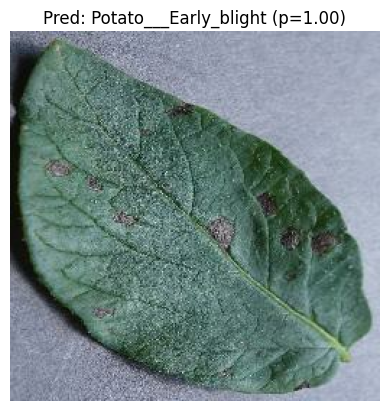

Probs: {'Potato___Early_blight': 1.0, 'Potato___Late_blight': 0.0, 'Potato___healthy': 0.0}


(0, array([1., 0., 0.], dtype=float32))

In [73]:
dataset_path = "plantvillage dataset/color"
vegetable_leaf = "Potato___Early_blight"
specific_img = "00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG"
early_blight = os.path.join(dataset_path, vegetable_leaf, specific_img)
# Ejecuta
predict_external_image(early_blight)

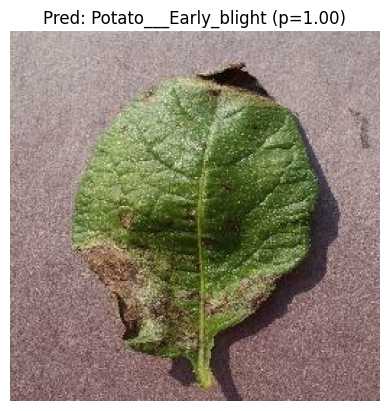

Probs: {'Potato___Early_blight': 1.0, 'Potato___Late_blight': 0.0, 'Potato___healthy': 0.0}


(0, array([1., 0., 0.], dtype=float32))

In [74]:
dataset_path = "plantvillage dataset/color"
vegetable_leaf = "Potato___Late_blight"
specific_img = "00b1f292-23dd-44d4-aad3-c1ffb6a6ad5a___RS_LB 4479.JPG"

late_blight = os.path.join(dataset_path, vegetable_leaf, specific_img)

predict_external_image(late_blight)

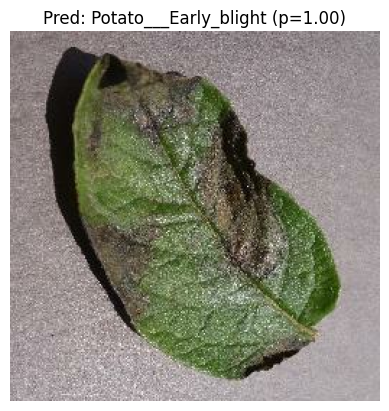

Probs: {'Potato___Early_blight': 1.0, 'Potato___Late_blight': 0.0, 'Potato___healthy': 0.0}


(0, array([1., 0., 0.], dtype=float32))

In [75]:

dataset_path = "plantvillage dataset/color"
vegetable_leaf = "Potato___Late_blight"
specific_img = "0f243024-b1fa-4f96-ac7e-ecaf6dc5bc37___RS_LB 4925.JPG"

late_blight_2 = os.path.join(dataset_path, vegetable_leaf, specific_img)

predict_external_image(late_blight_2)

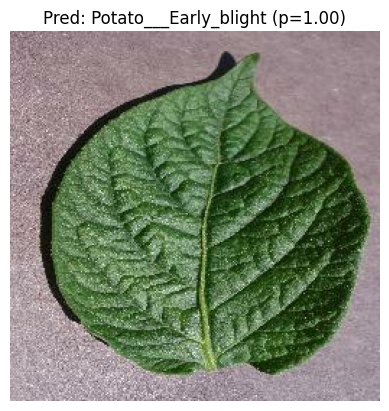

Probs: {'Potato___Early_blight': 1.0, 'Potato___Late_blight': 0.0, 'Potato___healthy': 0.0}


(0, array([1., 0., 0.], dtype=float32))

In [76]:

dataset_path = "plantvillage dataset/color"
vegetable_leaf = "Potato___healthy"
specific_img = "00fc2ee5-729f-4757-8aeb-65c3355874f2___RS_HL 1864.JPG"

Healthy = os.path.join(dataset_path, vegetable_leaf, specific_img)

predict_external_image(Healthy)